In [177]:
# pip install pandas
# pip install numpy
# pip install pickle
# pip install geopy
# pip install os
# pip install rasterio
# pip install geopandas
# pip install dbfread
# pip install matplotlib
# pip install shapely
# pip install dbfread
# pip install carto_auth

In [178]:
import pandas as pd
import numpy as np
import pickle
from geopy.geocoders import Nominatim
import os
import rasterio
import geodatasets
import geopandas as gpd
from dbfread import DBF
import xyzservices.providers as xyz
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
from shapely.ops import linemerge
from shapely.geometry import LineString
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import osmnx as ox
import requests

#### **Part 1: River Emissions data**

- Importing and cleaning the dataset used in the Ocean Cleanup's top 1000 rivers model
- For my model: interested in the ***top 10 polluting rivers in South East Asia***

In [179]:
# Path to the shapefile
shp_path = r'C:\Users\liamr\OneDrive\Documents\Playground\river_plastic_data\data\Meijer2021_midpoint_emissions.shp'


# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shp_path)

# Loading the .dbf file separately
dbf_path = r'C:\\Users\liamr\OneDrive\Documents\Playground\river_plastic_data\data\Meijer2021_midpoint_emissions.dbf'

dbf_data = DBF(dbf_path)


In [180]:
# Display the first few rows to understand the structure of the data
print(gdf.head())

   dots_exten                     geometry
0    0.164904  POINT (168.79792 -46.58083)
1    0.124932  POINT (168.34875 -46.44708)
2    1.213370  POINT (168.33708 -46.41875)
3    0.121138  POINT (168.02125 -46.35792)
4    0.197533  POINT (169.81125 -46.34375)


In [181]:
print(gdf[['dots_exten', 'geometry']].head(20))  # Check the first 20 rows


    dots_exten                     geometry
0     0.164904  POINT (168.79792 -46.58083)
1     0.124932  POINT (168.34875 -46.44708)
2     1.213370  POINT (168.33708 -46.41875)
3     0.121138  POINT (168.02125 -46.35792)
4     0.197533  POINT (169.81125 -46.34375)
5     0.179718  POINT (170.19708 -46.05292)
6     0.382871  POINT (170.39208 -45.92875)
7     0.144652  POINT (170.50958 -45.88875)
8     0.593496  POINT (170.51708 -45.87542)
9     0.236202  POINT (171.25958 -44.42167)
10    0.102279  POINT (171.25708 -44.36125)
11    0.129572  POINT (171.35042 -44.28125)
12    0.376397  POINT (172.37875 -43.85625)
13    2.268480  POINT (172.75042 -43.55125)
14    2.850020  POINT (172.72458 -43.48792)
15    0.503895  POINT (172.70708 -43.39125)
16    0.207065  POINT (147.33792 -42.88375)
17    0.108960  POINT (147.45792 -42.77792)
18    0.499766  POINT (171.19208 -42.43875)
19    0.362587  POINT (174.06208 -41.50125)


In [182]:
# Sort by emission values and filter top 1000
top_1000_rivers = gdf.sort_values(by='dots_exten', ascending=False).head(1000)


In [183]:
top_1000_rivers.head()

,dots_exten,geometry
12639,62591.9,POINT (120.95708 14.59542)
12656,13450.2,POINT (120.94833 14.64958)
16880,13432.9,POINT (72.91292 19.28958)
13361,12816.0,POINT (101.38875 3.00292)
12693,12398.3,POINT (120.90042 14.71708)


In [184]:
# Define bounding box for Southeast Asia (latitude and longitude ranges)
southeast_asia_rivers = top_1000_rivers[
    (top_1000_rivers.geometry.y > 0) & (top_1000_rivers.geometry.y < 20) &
    (top_1000_rivers.geometry.x > 90) & (top_1000_rivers.geometry.x < 120)
]


In [185]:
southeast_asia_rivers.count()

dots_exten    176
geometry      176
dtype: int64

##### ....176 of the top 1000 polluting rivers are located in South-East Asia

In [186]:
southeast_asia_rivers.head()

,dots_exten,geometry
13361,12816.00,POINT (101.38875 3.00292)
14525,4127.44,POINT (106.74708 10.49875)
15365,4027.33,POINT (100.55795 13.61573)
16338,3615.39,POINT (96.19083 16.77458)
7006,3274.70,POINT (110.39875 1.55542)


In [187]:
# Focusing on only SE Asia rivers - creating a longitude and latitude column
southeast_asia_rivers['lat'] = southeast_asia_rivers.geometry.apply(lambda p: round(p.y,5))
southeast_asia_rivers['lon'] = southeast_asia_rivers.geometry.apply(lambda p: round(p.x,5))

c:\Users\liamr\OneDrive\Documents\Playground\river_plastic\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\liamr\OneDrive\Documents\Playground\river_plastic\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [188]:
southeast_asia_rivers.head()

,dots_exten,geometry,lat,lon
13361,12816.00,POINT (101.38875 3.00292),3.00292,101.38875
14525,4127.44,POINT (106.74708 10.49875),10.49875,106.74708
15365,4027.33,POINT (100.55795 13.61573),13.61573,100.55795
16338,3615.39,POINT (96.19083 16.77458),16.77458,96.19083
7006,3274.70,POINT (110.39875 1.55542),1.55542,110.39875


In [189]:
southeast_asia_rivers = southeast_asia_rivers.rename(columns={'dots_exten': 'pollution_volume'})
southeast_asia_rivers.to_crs(epsg=4326)

,pollution_volume,geometry,lat,lon
13361,12816.000,POINT (101.38875 3.00292),3.00292,101.38875
14525,4127.440,POINT (106.74708 10.49875),10.49875,106.74708
15365,4027.330,POINT (100.55795 13.61573),13.61573,100.55795
16338,3615.390,POINT (96.19083 16.77458),16.77458,96.19083
7006,3274.700,POINT (110.39875 1.55542),1.55542,110.39875
...,...,...,...,...
14778,177.417,POINT (109.00929 11.54262),11.54262,109.00929
13473,176.705,POINT (100.61625 4.44625),4.44625,100.61625
15815,175.480,POINT (95.71042 16.07542),16.07542,95.71042
16334,174.970,POINT (96.12542 16.76208),16.76208,96.12542


In [190]:
# Rank the rivers by plastic volume in descending order (higher plastic volume = higher rank)
southeast_asia_rivers['rank'] = southeast_asia_rivers['pollution_volume'].rank(ascending=False, method='dense').astype(int)

# Sort the DataFrame by rank if you want to see the order
southeast_asia_rivers = southeast_asia_rivers.sort_values(by='rank')

# top 10 polluting rivers in SE Asia
SE_top_10 = southeast_asia_rivers.head(10)
# SE_top_10_pts = SE_top_10[['lon', 'lat','geometry', 'pollution_volume']]

#### **Part 2: Integrating Climate Data**


- ***For 1st model:  Precipitation data from WorldClim2***

- Optional Future Enhancement: Wind data from WorldClim2
- Optional Future Enhancement: Land Use and Terrain Data -> from HYDROATLAS or GLAD Land Use
- Optional Future Enhancement: Waste Management Data -> The World Bank’s What a Waste database


Integration Plan:

- Integrate these as monthly variables tied to each river
- Historical climate averages then to be used to model how changes in precipitation and wind seasonally impact plastic mobilization P(M)

#### **Part 2: River names and country**

##### importing data for central river locations and river basins:

In [191]:
# The river name data was faulty -> 4 clearly separate rivers all named Indragi. Will leave this part out for now
natural_earth_rivers = r'C:\Users\liamr\OneDrive\Documents\Playground\river_plastic_data\data\ne_50m_rivers_lake_centerlines\ne_50m_rivers_lake_centerlines.shp'

natural_earth_gdf = gpd.read_file(natural_earth_rivers)

natural_earth_gdf = natural_earth_gdf.to_crs(epsg=4326)

# from hydroRIVERS
hydro_rivers_shp = r'C:\Users\liamr\OneDrive\Documents\Playground\river_plastic_data\data\HydroRIVERS_v10_as_shp\HydroRIVERS_v10_as.shp'
hydro_rivers_gdf = gpd.read_file(hydro_rivers_shp)
hydro_rivers_gdf = hydro_rivers_gdf.to_crs(epsg=4326)

# Checking the crs for both geo datasets are matching
print(natural_earth_gdf.crs)
print(hydro_rivers_gdf.crs)
print(SE_top_10.crs)
print(natural_earth_gdf.crs == SE_top_10.crs)

EPSG:4326
EPSG:4326
EPSG:4326
True


##### reducing river basins to only those that intersect with the rivers from SE_top_10 dataset:

In [192]:
hydro_rivers_gdf.head()

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,40000001,40000019,40017702,2.48,3056.6,6.9,14.93,14.9,0,0.133,1,5,7,4121166050,"LINESTRING (124.60417 55.87708, 124.61875 55.8..."
1,40000002,40000019,40017702,1.23,3056.8,6.0,12.76,12.8,0,0.120,1,6,7,4121166050,"LINESTRING (124.63542 55.88333, 124.63542 55.8..."
2,40000003,40000015,40017702,1.26,3052.8,7.4,11.80,11.8,0,0.100,1,7,7,4120080930,"LINESTRING (125.24583 55.85417, 125.23958 55.8..."
3,40000004,40000015,40017702,1.30,3052.6,7.9,2.17,24.9,0,0.195,2,6,7,4120080930,"LINESTRING (125.26042 55.84375, 125.23958 55.8..."
4,40000005,40000004,40017702,0.69,3054.1,6.4,10.84,10.8,0,0.090,1,7,8,4120080930,"LINESTRING (125.26042 55.85, 125.26042 55.84375)"


In [193]:
SE_top_10

,pollution_volume,geometry,lat,lon,rank
13361,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1
14525,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2
15365,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3
16338,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4
7006,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5
13349,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6
16367,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7
13615,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8
13414,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9
13241,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10


In [194]:
# Reduce hydro rivers to only those intersecting SE_top_10 rivers
selected_rivers_hydro = gpd.sjoin_nearest(SE_top_10, hydro_rivers_gdf, how='left', distance_col='distance_to_river')

# Drop duplicates
selected_rivers_hydro = selected_rivers_hydro.drop_duplicates(subset='geometry')



c:\Users\liamr\OneDrive\Documents\Playground\river_plastic\.venv\Lib\site-packages\geopandas\array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [195]:
selected_rivers_hydro

,pollution_volume,geometry,lat,lon,rank,index_right,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,...,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,distance_to_river
13361,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,1424551,41424552,0,41424552,4.47,...,96.8,13.72,1254.9,0,64.383,4,1,5,4120020820,0.000833
14525,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,1386178,41386179,0,41386179,6.95,...,533.2,12.66,29759.0,0,1278.321,6,1,3,4120016810,0.000833
15365,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,1337890,41337891,0,41337891,2.39,...,1051.1,8.14,144308.0,0,835.933,7,1,4,4120018280,0.000931
16338,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,1274221,41274222,0,41274222,2.17,...,121.5,5.96,1597.3,0,100.501,5,1,4,4120023360,0.000884
7006,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,1428904,41428905,0,41428905,10.10,...,11.7,26.18,26.0,0,1.084,1,1,6,4120020320,6.119862
13349,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6,1425257,41425258,0,41425258,1.12,...,115.2,6.65,2137.3,0,83.592,5,1,5,4120020780,0.001179
16367,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7,1272610,41272611,0,41272611,1.75,...,293.0,3.08,7925.0,0,423.701,5,1,4,4120023380,0.001179
13615,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8,1409372,41409373,0,41409373,0.65,...,323.2,1.28,13166.4,0,493.920,6,1,4,4120019710,0.001179
13414,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9,1421372,41421373,0,41421373,0.65,...,85.0,1.50,1684.8,0,86.519,5,1,5,4120020020,0.000589
13241,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10,1428779,41428780,0,41428780,2.24,...,30.4,7.72,196.1,0,8.344,3,1,6,4120020420,0.000417


In [196]:
top_river_ids = selected_rivers_hydro['MAIN_RIV'].unique()

# Filter the HydroRIVERS dataset for all segments belonging to those rivers
full_river_segments = hydro_rivers_gdf[hydro_rivers_gdf['MAIN_RIV'].isin(top_river_ids)]

# the NEXT_DOWN column shows the next downstream line segment, 
# with 0 being the segment at the river draining into ocean or inland sink
# will start from the matched segment from the hydroRIVERS join, and collect each 
# segment until 0 to get a river line for the vizualisation




# def trace_river_path(start_segment_id, hydro_rivers_gdf):
#     river_path = []
#     segment_map = hydro_rivers_gdf.set_index('HYRIV_ID')

#     current_id = start_segment_id

#     while pd.notnull(current_id) and current_id in segment_map.index:
#         segment = segment_map.loc[current_id]
#         river_path.append(segment.geometry)
#         current_id = segment['NEXT_DOWN']

#     return river_path


# simplified_rivers = []

# for idx, row in selected_rivers_hydro.iterrows():
#     start_id = row['HYRIV_ID']
#     traced_segments = trace_river_path(start_id, hydro_rivers_gdf)
#     if traced_segments:
#         merged_line = linemerge(traced_segments)
#         simplified_rivers.append({'geometry': merged_line, 'name': row['name'], 'rank': row['rank']})

# # Create GeoDataFrame
# simplified_river_gdf = gpd.GeoDataFrame(simplified_rivers, crs=hydro_rivers_gdf.crs)



##### getting country names:

In [197]:
import time

In [198]:
# User agent sets my unique identifier when making API requests to Nominatum (required in Terms of Service)
geolocator = Nominatim(user_agent="river_locator")

# creating function which uses the lon and lat coordinates to reverse code and find the country
def get_country(lat, lon):
    time.sleep(1)
    location = geolocator.reverse((lat, lon), language='en')
    country = location.raw.get('address', {}).get('country', None)
    return country

# Applying the function to DataFrame
# SE_top_10_pts.loc[:, 'river_name'] = SE_top_10_pts.apply(lambda row: get_river_name(row['lat'], row['lon']), axis=1)
SE_top_10.loc[:, 'country'] = SE_top_10.apply(lambda row: get_country(row['lat'], row['lon']), axis=1)

southeast_asia_rivers_top_10 = SE_top_10.copy()


c:\Users\liamr\OneDrive\Documents\Playground\river_plastic\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


##### getting river names:

###### natural earth dataset gave innacurate name data, so leaving this part out

In [199]:
# using gpd spatial join to find the nearest river (from Natural Earth dataset) that corresponds to the longitude and latitude coordinates
# river_names_join = gpd.sjoin_nearest(SE_top_10, natural_earth_gdf, how="left", distance_col="distance")


# river_names = river_names_join[['pollution_volume','geometry','lat','lon','rank','country','name']]

### Map Visualisation

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


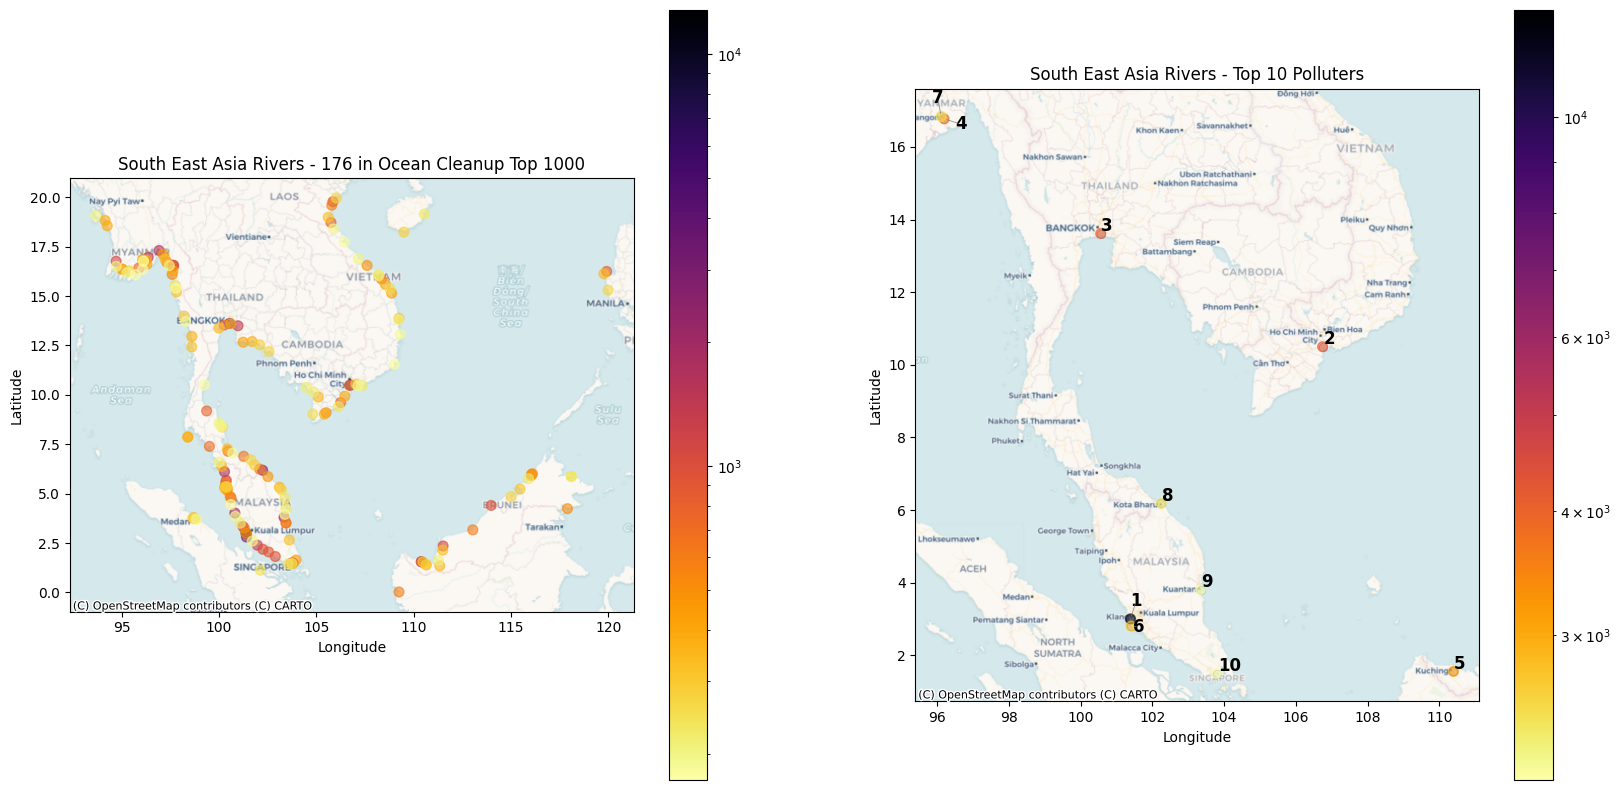

In [201]:
from matplotlib.colors import LogNorm
import adjustText as aT
# defining variables to be used when plotting
pollution_ranks = southeast_asia_rivers_top_10['rank']
geometries = southeast_asia_rivers_top_10['geometry']

# make figure with subplots
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot all 176 SE Asia rivers in the top 1000
southeast_asia_rivers.plot(column='pollution_volume', ax=ax1, legend=True,
         cmap='inferno_r', markersize=50, alpha=0.6, norm=LogNorm())

# Plotting the river basins on ax2
southeast_asia_rivers_top_10.plot(ax=ax2, facecolor='lightblue', edgecolor='blue', linewidth=0.5, alpha=0.4)

# Plotting top 10 polluting rivers
southeast_asia_rivers_top_10.plot(column='pollution_volume', ax=ax2, legend=True,
         cmap='inferno_r', markersize=50, alpha=0.6, norm=LogNorm())

# Add basemaps for both axes
ctx.add_basemap(ax1, crs=southeast_asia_rivers.crs, source=ctx.providers.CartoDB.Voyager)
ctx.add_basemap(ax2, crs=southeast_asia_rivers.crs, source=ctx.providers.CartoDB.Voyager)

# plotting the text tables for ax2
texts = []
for r, g in zip(pollution_ranks, geometries):
    xy = g.coords[0]
    texts.append(ax2.text(xy[0], xy[1], r, weight='bold', size='large'))

# And NOW we adjust those points so that they no longer overlap
aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

# Set title and labels
ax1.set_title('South East Asia Rivers - 176 in Ocean Cleanup Top 1000')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Set title and labels
ax2.set_title('South East Asia Rivers - Top 10 Polluters')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Show the plot
plt.show()

#### **Part 3: Integrating Climate Data**


- ***For 1st model:  Precipitation data from WorldClim2***

- Optional Future Enhancement: Wind data from WorldClim2
- Optional Future Enhancement: Land Use and Terrain Data -> from HYDROATLAS or GLAD Land Use
- Optional Future Enhancement: Waste Management Data -> The World Bank’s What a Waste database


Integration Plan:

- Integrate these as monthly variables tied to each river
- Historical climate averages then to be used to model how changes in precipitation and wind seasonally impact plastic mobilization P(M)

for every location, I need to extract the average precipitation

In [203]:
# Rasterio is used to process the .tif file
# Processing the precipitation .tif files decade by decade

# Folder where each decade of precipitation data is stored
base_dir = r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\rain_decades'

# selecting the coordinates from the top polluting rivers
southeast_asia_rivers_top_10 = southeast_asia_rivers_top_10.copy()
# arranging the index so it starts at 1
southeast_asia_rivers_top_10.index = np.arange(1, len(southeast_asia_rivers_top_10) + 1)
# coordinates to be used for extracting from the raster
coords = [(x,y) for x, y in zip(southeast_asia_rivers_top_10['lon'], southeast_asia_rivers_top_10['lat'])]

# Initialize list to store all the data to be parsed
time_series_data = []

# Initializing month and year variables, starting from the first month of data
month = 1
year = 1960

# Iterate through each folder in the base directory, in chronological order
for decade_folder in sorted(os.listdir(base_dir)):
    decade_folder_path = os.path.join(base_dir, decade_folder)

    # using if statement to ensure logic is only carried out on a decade folder
    if os.path.isdir(decade_folder_path):
        # Now iterating through each file in the current decade folder
        for rain_file in sorted(os.listdir(decade_folder_path)):
                 # To avoid the readme.txt file in the folders
                 if rain_file.endswith('.tif'):
                    # state the file path as an input for rasterio
                    rain_file_path = os.path.join(decade_folder_path, rain_file)
                    with rasterio.open(rain_file_path) as src_rain:
                    # Extract the precipitation values for every rivers, given the coordinates
                        sampled_values_rain = [val[0] for val in src_rain.sample(coords)]
                        

                # Create a DataFrame for the current month
                    month_data = pd.DataFrame({
                        'river_ID': southeast_asia_rivers_top_10.index, # Adding unique IDs or indices for rivers. For top 10 SE rivers, this is in order of yearly plastic pollution
                        'country': southeast_asia_rivers_top_10['country'],
                        'lon': southeast_asia_rivers_top_10['lon'],
                        'lat': southeast_asia_rivers_top_10['lat'],
                        'year': year,  
                        'month': month,
                        'avg_precipitation': sampled_values_rain
                    })

                    # Finally, appending each month to the time_series_data list
                    time_series_data.append(month_data)

                    # logic for assigning the correct month
                    if month < 12:
                        month += 1
                    elif month == 12:
                        month = 1 
                        year += 1
                    


In [204]:
time_series_data

[    river_ID   country        lon       lat  year  month  avg_precipitation
 1          1  Malaysia  101.38875   3.00292  1960      1         263.625000
 2          2   Vietnam  106.74708  10.49875  1960      1           4.725000
 3          3  Thailand  100.55795  13.61573  1960      1           4.750000
 4          4   Myanmar   96.19083  16.77458  1960      1           7.125000
 5          5  Malaysia  110.39875   1.55542  1960      1         717.250000
 6          6  Malaysia  101.41125   2.80458  1960      1         254.233337
 7          7   Myanmar   96.10625  16.84125  1960      1           7.175000
 8          8  Malaysia  102.24458   6.18208  1960      1         274.325012
 9          9  Malaysia  103.34292   3.80625  1960      1         514.099976
 10        10  Malaysia  103.79750   1.49625  1960      1         168.600006,
     river_ID   country        lon       lat  year  month  avg_precipitation
 1          1  Malaysia  101.38875   3.00292  1960      2         125.65000

In [205]:
ts_df = pd.concat(time_series_data, ignore_index=True)
ts_df

,river_ID,country,lon,lat,year,month,avg_precipitation
0,1,Malaysia,101.38875,3.00292,1960,1,263.625
1,2,Vietnam,106.74708,10.49875,1960,1,4.725
2,3,Thailand,100.55795,13.61573,1960,1,4.750
3,4,Myanmar,96.19083,16.77458,1960,1,7.125
4,5,Malaysia,110.39875,1.55542,1960,1,717.250
...,...,...,...,...,...,...,...
7195,6,Malaysia,101.41125,2.80458,2019,12,30.000
7196,7,Myanmar,96.10625,16.84125,2019,12,32.000
7197,8,Malaysia,102.24458,6.18208,2019,12,29.500
7198,9,Malaysia,103.34292,3.80625,2019,12,30.000


In [206]:
print(isinstance(ts_df, pd.DataFrame))

True


In [207]:
# pip install pyarrow.feather

In [210]:
southeast_asia_rivers_top_10.to_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\SE_top_10_pts.pkl')
ts_df.to_pickle(r'C:\\Users\\liamr\\OneDrive\Documents\\Playground\\river_plastic_data\\data\\ts_df.pkl')